In [ ]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch

from combo_dl.graph_tools import edge_vector_to_adjacency_matrix
from combo_dl.problems import StronglyRegularGraphs

device = torch.device("mps")

In [2]:
n = 10
k = 3
lambda_param = 0
mu = 1
problem = StronglyRegularGraphs(n, k, lambda_param, mu)
checkpoint_path = Path("../checkpoints/srg_10_3_0_1_20251006_1851/best.pt")
sys.path.insert(0, str(Path.cwd().parent / "src"))

In [3]:
checkpoint = torch.load(checkpoint_path)
edge_vector = checkpoint["best_construction"]

checkpoint_n = checkpoint["config"]["n"]
reward = checkpoint["best_reward"]

if n != checkpoint_n:
    print(f"❌ Checkpoint size ({checkpoint_n}) does not match problem definition ({n}).")

if edge_vector.dim() == 1:
    edge_vector = edge_vector.unsqueeze(0)

best_adj = edge_vector_to_adjacency_matrix(edge_vector, n).squeeze(0)

print(f"Graph size: {n} x {n}")
print(f"Stored reward: {checkpoint['best_reward']:.6f} (Goal: 0.0)")
print(f"Iteration: {checkpoint['iteration']}")
print("\nAdjacency matrix:")
print(best_adj.numpy().astype(int))

Graph size: 10 x 10
Stored reward: -20.000000 (Goal: 0.0)
Iteration: 200

Adjacency matrix:
[[0 1 0 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 0 0 0 1]
 [0 0 1 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 1 0 1]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 1 0 0 1 0]]


In [4]:
degrees = best_adj.sum(dim=1)
print(f"Degree range: {degrees.min()}-{degrees.max()}, target: 20")
print(f"Vertices with wrong degree: {(degrees != 20).sum().item()}/{69}")
print()

eigenvalues = torch.linalg.eigvalsh(best_adj.float())
# Prepare table of unique eigenvalues and their counts
rounded_eigs = eigenvalues.round(decimals=1)
unique_eigs, counts = torch.unique(rounded_eigs, return_counts=True)
eig_table = pd.DataFrame({
    "Eigenvalue": [f"{eig.item():.1f}" for eig in unique_eigs],
    "Multiplicity": [count.item() for count in counts],
})

print(eig_table.to_string(index=False))

Degree range: 2.0-4.0, target: 20
Vertices with wrong degree: 10/69

Eigenvalue  Multiplicity
      -2.4             1
      -2.0             2
      -0.8             1
      -0.1             1
       1.0             3
       1.5             1
       2.9             1


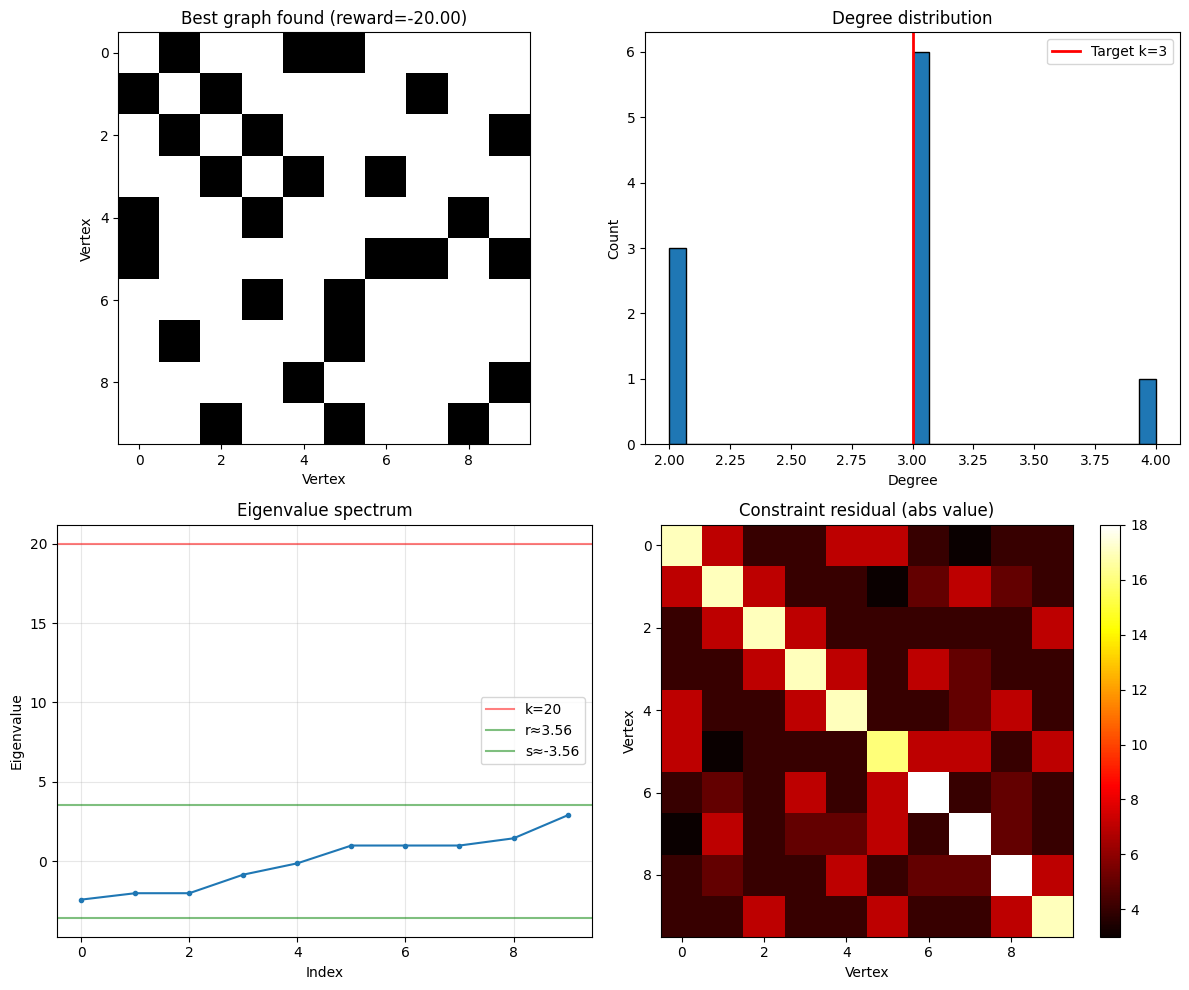


Residual norm: 73.53


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(best_adj.numpy(), cmap="binary")
axes[0, 0].set_title(f"Best graph found (reward={reward:.2f})")
axes[0, 0].set_xlabel("Vertex")
axes[0, 0].set_ylabel("Vertex")

# Degree distribution
axes[0, 1].hist(degrees.numpy(), bins=30, edgecolor="black")
axes[0, 1].axvline(k, color="r", linewidth=2, label=f"Target k={k}")
axes[0, 1].set_title("Degree distribution")
axes[0, 1].set_xlabel("Degree")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend()

# Eigenvalue spectrum
sorted_eigs = sorted(eigenvalues.numpy())
axes[1, 0].plot(sorted_eigs, "o-", markersize=3)
axes[1, 0].axhline(20, color="r", alpha=0.5, label="k=20")
axes[1, 0].axhline(3.56, color="g", alpha=0.5, label="r≈3.56")
axes[1, 0].axhline(-3.56, color="g", alpha=0.5, label="s≈-3.56")
axes[1, 0].set_title("Eigenvalue spectrum")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Eigenvalue")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Compute and visualize residual matrix
A_float = best_adj.float().unsqueeze(0)
A2 = A_float @ A_float
I = torch.eye(n).unsqueeze(0)
J = torch.ones(1, n, n)
residual = A2 + (5 - 7) * A_float + (5 - 20) * I - 5 * J
residual = residual.squeeze()

im = axes[1, 1].imshow(residual.abs().numpy(), cmap="hot")
axes[1, 1].set_title("Constraint residual (abs value)")
axes[1, 1].set_xlabel("Vertex")
axes[1, 1].set_ylabel("Vertex")
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.savefig("srg_diagnostic.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nResidual norm: {torch.norm(residual, p='fro'):.2f}")

AttributeError: 'float' object has no attribute 'item'

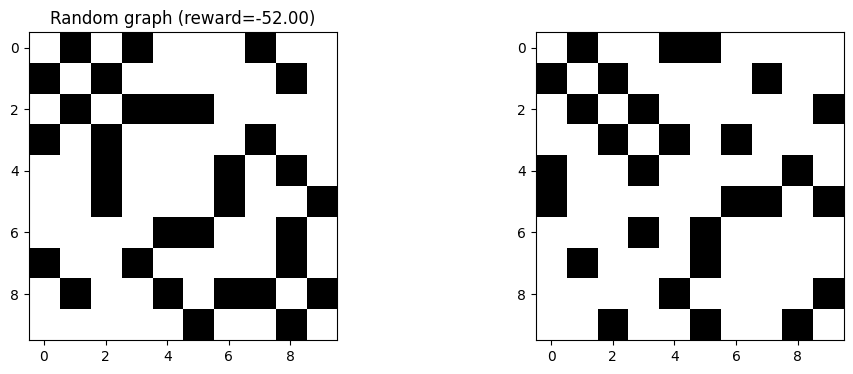

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
num_random_graphs: int = 1000

# Vectorized random edge vectors
random_edge_vecs: torch.Tensor = torch.randint(
    0, 2, (num_random_graphs, problem.edges()), device=device
)
# Vectorized conversion to adjacency matrices
random_adjs_tensor: torch.Tensor = edge_vector_to_adjacency_matrix(random_edge_vecs, n).to(device)
# Vectorized reward computation
with torch.no_grad():
    random_rewards_tensor: torch.Tensor = problem.reward(random_adjs_tensor)

# Keep everything on device until we need to convert for visualization
random_rewards: list[float] = random_rewards_tensor.tolist()
random_adjs: list[torch.Tensor] = list(random_adjs_tensor)

best_random_idx: int = int(torch.tensor(random_rewards).argmax())
random_adj = random_adjs[best_random_idx]
random_reward = random_rewards[best_random_idx]

axes[0].imshow(random_adj.cpu().numpy(), cmap="binary")
axes[0].set_title(f"Random graph (reward={random_reward:.2f})")

axes[1].imshow(best_adj.cpu().numpy(), cmap="binary")
axes[1].set_title(f"Your best graph (reward={reward.item():.2f})")

plt.tight_layout()
plt.savefig("random_vs_trained.png", dpi=150)
plt.show()

print(f"Random reward: {random_reward:.2f}")
print(f"Your reward: {reward.item():.2f}")
print(f"Improvement: {reward.item() - random_reward:.2f}")

print(f"Parameters: n={n}, k={k}, lambda={lambda_param}, mu={mu}")

if reward.item() > random_reward:
    print("✅ Model is better than random!")
else:
    print("❌ Model is not better than random - something is wrong")